# TD6. Introduction to Convolutional neural networks

In [260]:
import github_command as git

In [ ]:
git.push(file_to_transfer='TD6_CNN.ipypnb')

In [226]:
import os
import random
import matplotlib.pyplot as plt

In [85]:
%matplotlib inline

In [227]:
[x for x in os.listdir('./') if x.startswith('data')]

['data_dog', 'data_cat', 'data_accidents']

In [228]:
random.choices(os.listdir('data_dog'), k=3)

['2502.jpg', '3717.jpg', '528.jpg']

In [257]:
def show_k_images(path, k=3):
    import matplotlib.pyplot as plt
    from PIL import Image # used for loading images
    nb_cols = 2 if k%2 == 0 else 3
    fig, axes = plt.subplots(figsize=(nb_cols*5,k//nb_cols*5), nrows=k//nb_cols + k%nb_cols, ncols=nb_cols)
    for ax, (ax_number, choice) in zip(axes.flat, enumerate(random.choices(os.listdir(path), k=k))):
        ax.imshow(X=Image.open(path+choice))

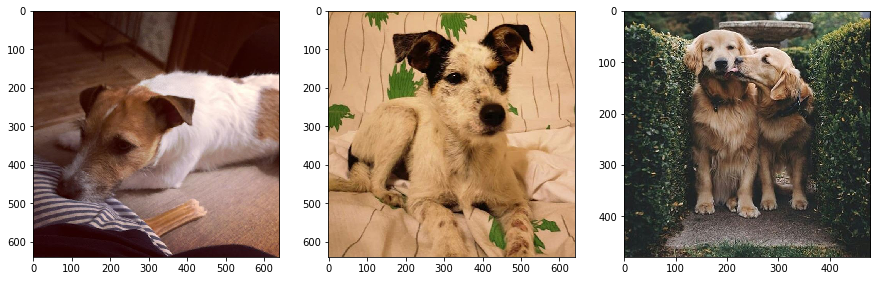

In [258]:
show_k_images('data_dog/', 3)

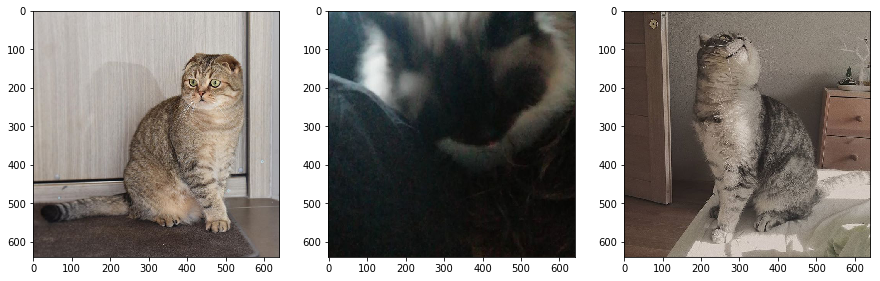

In [259]:
show_k_images('data_cat/', 3)